# BAU Evaluation and elements of concern 

author: Katherine Shaw

Date: August 21  

Previous Purpose of Document: the role of this document is to validated the 2020 year produced by the model to actual entoso-e and EU data to ensure the model's behavior aligns with realistic developments, and if not, answer why. 
## Instead of this file look at "BAU_Validationa_(&Evaluation)_notebook_clean.ipynb"

New Purpose of this Document:
Last Validation Check and hiked hydrogen prices to see how low we can go. 

In [2]:
#Packages 
import pypsa
import matplotlib.pyplot as plt 
import cartopy 
import geopandas
import networkx
import linopy
import cartopy.crs as ccrs
import atlite 
import geopandas as gpd 
import xarray
import pandas as pd 
from datetime import datetime
import numpy as np
from pypsa.plot import add_legend_patches
import random
import plotly.graph_objects as go

## Overall view of colors matched to carriers 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

#importing auxillary functions
import Auxillary_Functions as af

- build monthly prices 
- DLR 
- more weather years 
- carbon stores vs carbon sequestration 
- dac vs no dac done elsewhere 

In [10]:
def hydrogen_capacity_graphs(network_list): 
    hydrogen_tech_list = ['H2 Electrolysis', 'SMR', 'SMR CC', 'H2 pipeline', 'H2 pipeline retrofitted', 'H2 Fuel Cell'] #H2 turbine (apparently doesn't exist in Scenario 3)
    hydrogen_tech_tuple_list = [('Link', tech) for tech in hydrogen_tech_list]
    networks1 = network_list
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
    axes = axes.flatten()  # make it easier to iterate

    for i, tech in enumerate(hydrogen_tech_tuple_list):
        carrier_type, technology = tech
        mean_value = []
        mean_value_optimal = []
        for net in networks1:
            if technology in net.statistics().loc[carrier_type].index:
                stats = net.statistics().loc[carrier_type, technology]
                mean_value.append(stats['Installed Capacity'])
                mean_value_optimal.append(stats['Optimal Capacity'])
            else:
                mean_value.append(0)
                mean_value_optimal.append(0)
    
        ax = axes[i]
        ax.scatter([2020, 2030, 2040, 2050], mean_value, label='Installed Capacity', alpha=0.5)
        ax.scatter([2020, 2030, 2040, 2050], mean_value_optimal, label='Optimal Capacity', alpha=0.5)
        ax.set_title(f'{technology}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Capacity, MW')
        ax.legend()

    plt.tight_layout()
    plt.show()

## BAU without high hydrogen price alaterations

In [5]:
BAU_without_hydrogen_projections2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU_no_h2_limits/networks/base_s_39___2020.nc')
BAU_without_hydrogen_projections2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU_no_h2_limits/networks/base_s_39___2030.nc')
BAU_without_hydrogen_projections2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU_no_h2_limits/networks/base_s_39___2040.nc')
BAU_without_hydrogen_projections2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU_no_h2_limits/networks/base_s_39___2050.nc')

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [ ]:
def test_function(network_choice):    
    network = network_choice
    #data from network
   #data from network
    renewable_carriers = ['solar', 'solar-hsat', 'onwind', 'offwind-ac', 'offwind-dc', 'offwind-float', 'hydro', 'solar rooftop', 'ror'] #no solar thermal, though an argument could perhaps be made
    low_carbon_carriers = ['nuclear', 'geothermal']
    traditional_carriers = ['lignite', 'coal', 'oil primary', 'gas', 'biogas', 'solid biomass', ]

    #all buses that are acceptable 
    electric_buses = network.buses[network.buses.unit == 'MWh_el'].index #AC, battery, EV battery, low voltage, home battery 
    renewable_generators = network.generators[network.generators.carrier.isin(renewable_carriers)]
    renewable_generators = renewable_generators[renewable_generators.bus.isin(electric_buses)]
    renewable_generators = renewable_generators.index

    low_carbon_generators = network.generators[network.generators.carrier.isin(low_carbon_carriers)]
    low_carbon_generators = low_carbon_generators[low_carbon_generators.bus.isin(electric_buses)]
    low_carbon_generators = low_carbon_generators.index

    #conventional generators harder to nab, if I want to get to what was contributed to the power sector, have to take a different approach 
    conventional_generators = network.generators[network.generators.carrier.isin(traditional_carriers)]
    #conventional_generators = conventional_generators[conventional_generators.bus.isin(electric_buses)]
    #conventional_generators = conventional_generators.index 
    conventional_generators

    network.links.carrier.unique()
    #need all the links that come from a conventional bus and go into a electric bus
    thermal_to_power = network.links[network.links.bus1.isin(electric_buses)][~network.links.bus0.isin(electric_buses)]
    thermal_to_power = thermal_to_power[~(thermal_to_power.carrier == 'nuclear')]#get rid of all nuclear, because that is one I already have in low carbon power
    thermal_to_power = thermal_to_power.index 

    renewable_production = (network.generators_t.p[renewable_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    low_carbon_production = (network.generators_t.p[low_carbon_generators] * network.snapshot_weightings.objective[0]).T.groupby(network.generators.carrier).sum().T.sum() #MWh 
    conventional_production =  (network.links_t.p1[thermal_to_power] * network.snapshot_weightings.objective[0]).T.groupby(network.links.carrier).sum().T.sum() #MWh
    conventional_production = conventional_production * -1 #because it's power delivered to the electric bus 

    #hydro
    hydro_dispatch = network.storage_units_t.p.T.groupby(network.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
    hydro_dispatch = hydro_dispatch * network.snapshot_weightings.objective[0] #MW --> MWh

test_function(BAU_without_hydrogen_projections2050)

carrier
offwind-ac       1.403230e+08
offwind-dc       5.180883e+08
offwind-float    3.594764e+00
onwind           1.295320e+09
ror              1.543803e+08
solar            2.398668e+08
solar rooftop    4.683242e+08
solar-hsat       4.962967e+00
dtype: float64
carrier
geothermal    7.885078e+05
nuclear       6.672521e+08
dtype: float64


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/4265234333.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/4265234333.py:31: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/4265234333.py:32: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/4265234333.py:33: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

In [119]:
#hydro
hydro_dispatch = BAU_without_hydrogen_projections2050.storage_units_t.p.T.groupby(BAU_without_hydrogen_projections2050.storage_units.carrier).sum().sum(axis=1) #storage units are just hydro and phs 
hydro_dispatch = hydro_dispatch * BAU_without_hydrogen_projections2050.snapshot_weightings.objective[0] #MW --> MWh
hydro_dispatch

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3354249007.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



carrier
PHS     -6.488862e+06
hydro    3.115397e+08
dtype: float64

In [115]:
BAU_without_hydrogen_projections2050.statistics().loc['Link'].head(10)

,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
BEV charger,3.212047e+06,3.212047e+06,1.005585e+09,1.117317e+09,-1.117317e+08,0.000000e+00,0.039709,0.0,0.000000e+00,1.145626e+07,1.145626e+07,0.011393
Combined-Cycle Gas,8.676970e+04,8.676970e+04,2.878845e+06,3.797948e+06,-9.191030e+05,0.000000e+00,0.004997,0.0,5.389485e+09,1.005509e+07,1.922791e+08,66.790374
DAC,7.200000e-04,0.000000e+00,5.352870e+00,1.579097e+01,-1.043810e+01,0.000000e+00,0.472222,0.0,7.586977e+02,2.952000e-02,-1.722534e+01,-3.229508
DC,2.632672e+05,5.404000e+04,4.411622e+08,4.570663e+08,-1.590405e+07,4.570663e+08,0.198188,0.0,7.317294e+09,4.560480e+06,1.320616e+09,2.993493
Fischer-Tropsch,2.507383e+05,2.507383e+05,1.176702e+09,1.695157e+09,-5.184559e+08,0.000000e+00,0.640244,0.0,1.524491e+10,3.852424e+09,2.021158e+09,1.717647
H2 Electrolysis,5.088834e+05,5.088834e+05,2.229771e+09,3.187624e+09,-9.578534e+08,0.000000e+00,0.715064,0.0,7.722453e+10,6.378885e+07,3.433215e+09,1.539717
H2 Fuel Cell,3.580000e-03,0.000000e+00,6.097440e+00,9.992170e+00,-3.894730e+00,0.000000e+00,0.318436,0.0,2.917746e+02,9.984000e-02,-1.590526e+02,-25.942857
H2 pipeline,5.412223e+04,5.131750e+04,1.251829e+08,1.259895e+08,-8.065978e+05,1.251829e+08,0.264037,0.0,2.867586e+08,2.383539e+06,1.626497e+08,1.299297
H2 pipeline retrofitted,3.394456e+04,3.254508e+04,2.609229e+08,2.609229e+08,0.000000e+00,-5.525182e+07,0.877481,0.0,2.891521e+08,-1.138066e+06,1.612264e+08,0.617908
Open-Cycle Gas,5.828737e+01,5.827500e+01,6.679980e+00,1.065509e+01,-3.975110e+00,0.000000e+00,0.000021,0.0,1.160147e+06,2.188194e+01,-1.532783e+02,-23.026316


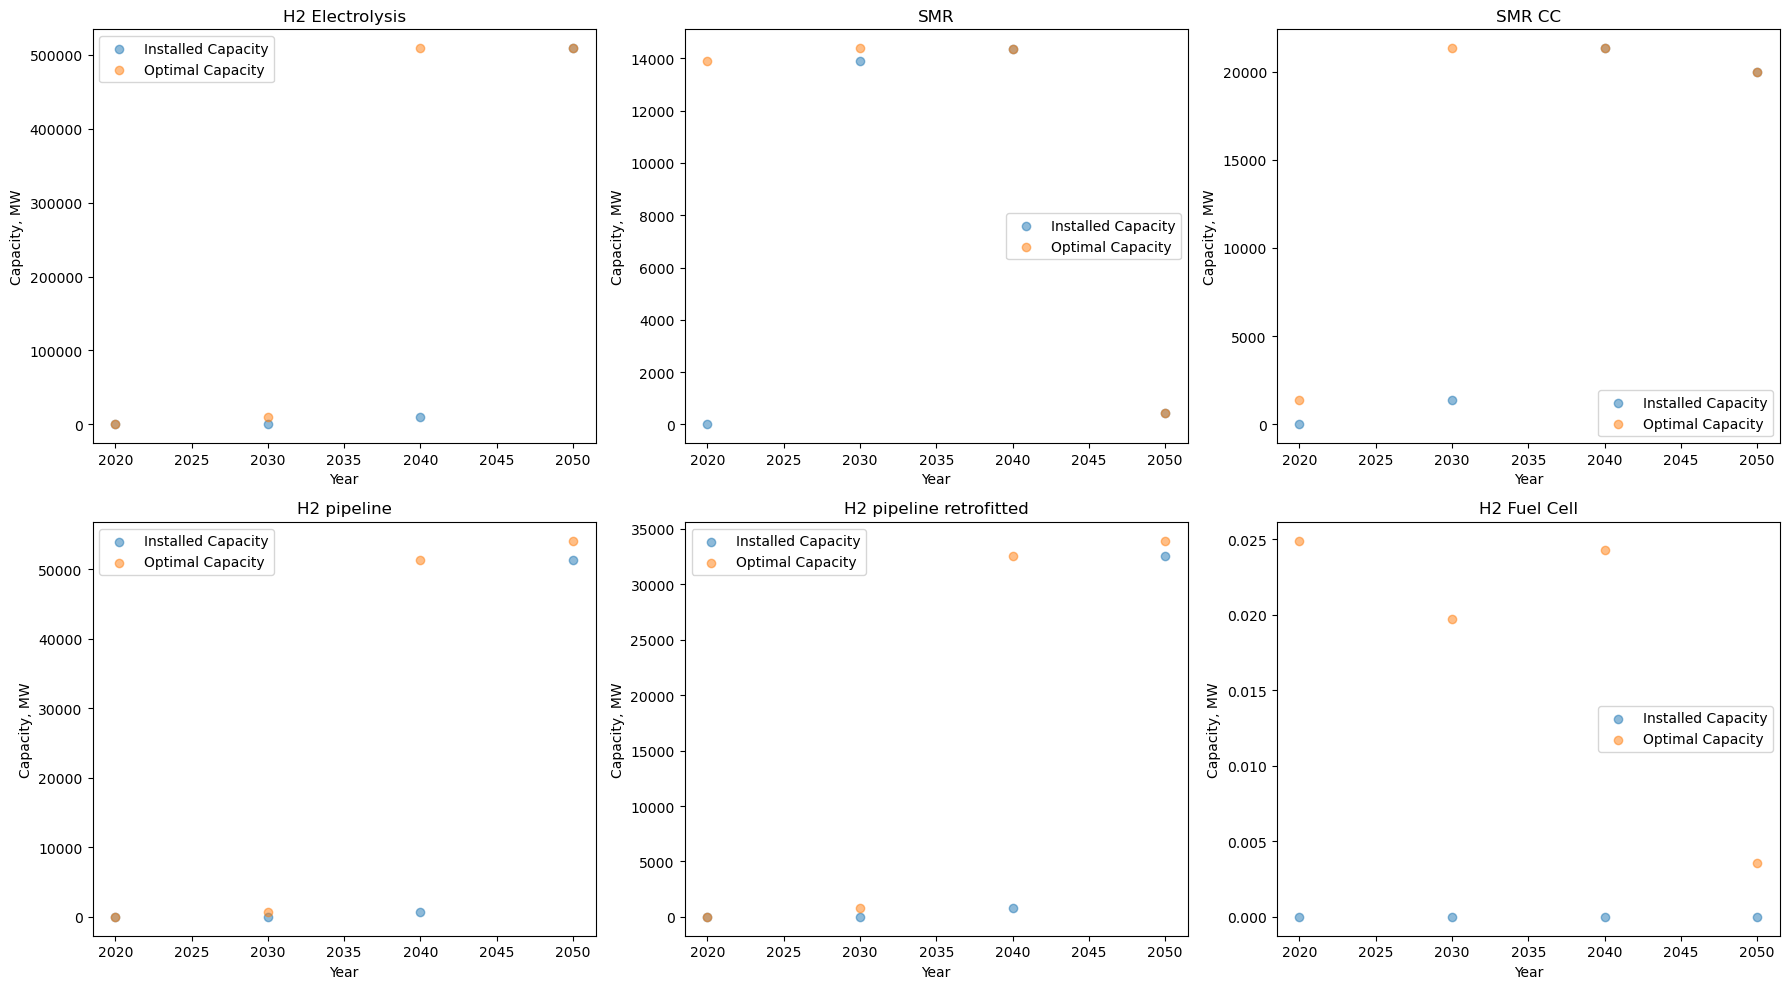

In [11]:
network_list = [BAU_without_hydrogen_projections2020, BAU_without_hydrogen_projections2030, BAU_without_hydrogen_projections2040, BAU_without_hydrogen_projections2050]
hydrogen_capacity_graphs(network_list)

#### Cost file changes 

In [12]:
#loading costs files 
costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2020.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value

#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 

cost_file.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv', index = False)



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:16: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:24: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:31: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:38: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3474567152.py:46: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [13]:
#2030 
#loading costs files 
#costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
#costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
#costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
#costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2030.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value

#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 

cost_file.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv', index = False)



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:39: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3593245672.py:47: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [14]:
##2040 
#loading costs files 
#costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
#costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
#costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
#costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2040.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value

#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 

cost_file.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv', index = False)



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:39: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/3673042299.py:47: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [15]:
## 2050
#loading costs files 
#costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
#costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
#costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
#costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2050.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value

#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
new_value
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
new_value = old_value * 15 
cost_file.loc[electrolysis_index, 'value'] = new_value
cost_file.loc[electrolysis_index, 'value']


#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 

cost_file.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv', index = False)



/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:17: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:32: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:39: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/215727356.py:47: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


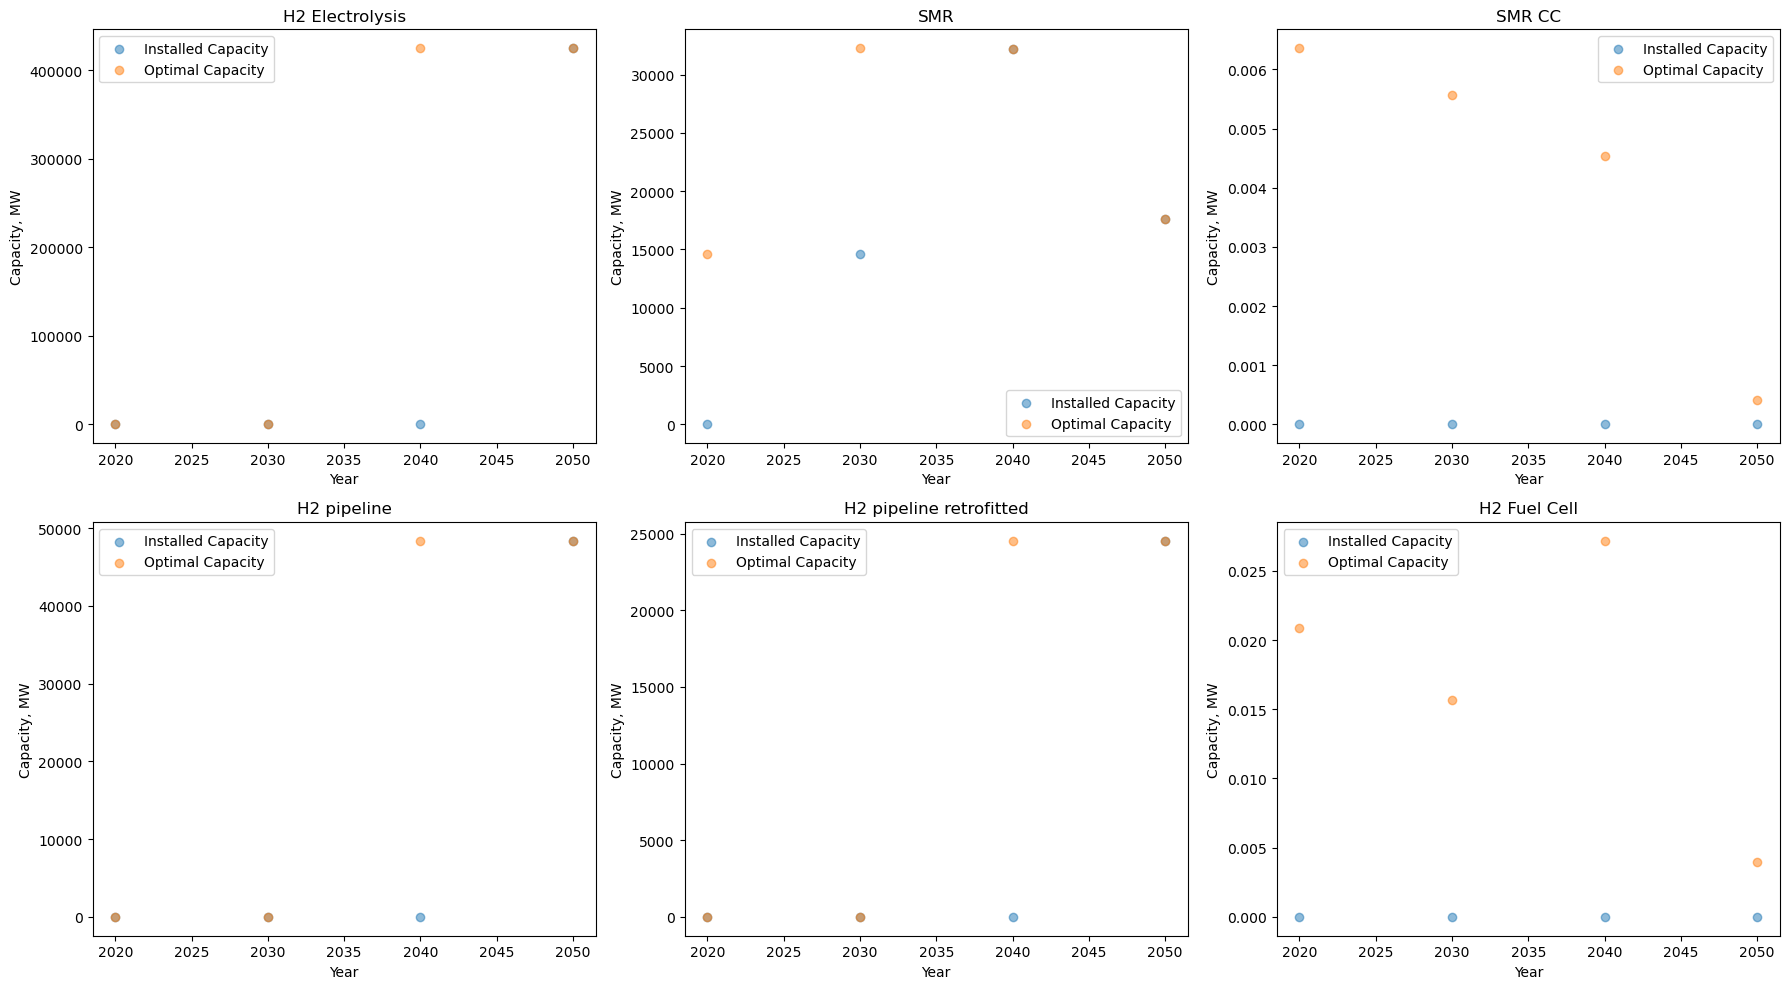

In [16]:
high_hydrogen_cost_network2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
high_hydrogen_cost_network2030 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc')
high_hydrogen_cost_network2040 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc')
high_hydrogen_cost_network2050 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc')
high_hydrogen_list = [high_hydrogen_cost_network2020, high_hydrogen_cost_network2030, high_hydrogen_cost_network2040,high_hydrogen_cost_network2050 ]
hydrogen_capacity_graphs(high_hydrogen_list)

SMR, being the cheapest, gets used instead of electrolysis or SMR CC. 

In [ ]:
high_hydrogen_list = [high_hydrogen_cost_network2020, high_hydrogen_cost_network2030, high_hydrogen_cost_network2040,high_hydrogen_cost_network2050 ]
hydrogen_tech

### What about when hydrogen costs from 2020 are propogated through? 

In [19]:
#loading costs files 
costs_2020 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2020.csv')
costs_2030 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv')
costs_2040 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv')
costs_2050 = pd.read_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv')

#Electrolysis 
cost_file = costs_2020.copy()
electrolysis_index = cost_file[cost_file.technology == 'electrolysis'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f'Electrolysis old value {old_value}')
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value


#Electrlysis Small 
electrolysis_index = cost_file[cost_file.technology == 'electrolysis small'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f"Electrolysis Small Old Value {old_value}")
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value


#SMR 
electrolysis_index = cost_file[cost_file.technology == 'SMR'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f'SMR old value {old_value}')
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value



#the second steam methane reforming 
electrolysis_index = cost_file[cost_file.technology == 'Steam methane reforming'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f'Steam methan reforming old value {old_value}')
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value

#SMRCC
electrolysis_index = cost_file[cost_file.technology == 'SMR CC'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f'SMR CC old value {old_value}')
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value



#H2 Pipelines
electrolysis_index = cost_file[cost_file.technology == 'H2 pipeline'][cost_file.parameter == 'investment']['value'].index
old_value = cost_file.loc[electrolysis_index, 'value'].item() #= 10000.0 #need to use location based indexing
print(f'H2 pipeline old value {old_value}')
costs_2030.loc[electrolysis_index, 'value'] = old_value
costs_2040.loc[electrolysis_index, 'value'] = old_value
costs_2050.loc[electrolysis_index, 'value'] = old_value



#H2 Pipelines retrofitted 
#didn't find

#H2 fuel cell
#not necesary to minimize, I'm trying to find what is the least amoung of hydrogen 

costs_2030.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2030.csv', index = False)
costs_2040.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2040.csv', index = False)
costs_2050.to_csv('/Users/katherine.shaw/Desktop/pypsa-eur/resources/costs_2050.csv', index = False)



Electrolysis old value 2000.0
Electrolysis Small Old Value 1900.0
SMR old value 522201.0492
Steam methan reforming old value 497454.611
SMR CC old value 605753.2171
H2 pipeline old value 282.5452


/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:27: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:37: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:45: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/var/folders/_w/ry357l9n0vjg8jgfczvkpk3r0000gn/T/ipykernel_78635/1048071377.py:55: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [27]:
hydrogen_tech_list = ['H2 Electrolysis', 'SMR', 'SMR CC', 'H2 pipeline', 'H2 pipeline retrofitted', 'H2 Fuel Cell', 'H2 turbine'] #H2 turbine (apparently doesn't exist in Scenario 3)


In [26]:
high_hydrogen_list = [high_hydrogen_cost_network2020, high_hydrogen_cost_network2030, high_hydrogen_cost_network2040,high_hydrogen_cost_network2050 ]
year_list = [2020, 2030, 2040, 2050]
for year in range(len(year_list)):
    print(year_list[year])
    print('')
    for i in range(len(hydrogen_tech_list)):
        print(hydrogen_tech_list[i])
        optimal_capacity_option = high_hydrogen_list[year].statistics().loc[('Link', hydrogen_tech_list[i])]['Optimal Capacity']
        print(optimal_capacity_option)


2020

H2 Electrolysis
0.0016
SMR
14622.18327
SMR CC
0.00636
H2 pipeline
3.58529
H2 pipeline retrofitted
0.22903
H2 Fuel Cell
0.02087
2030

H2 Electrolysis
0.00136
SMR
32262.85776
SMR CC
0.00556
H2 pipeline
2.3101
H2 pipeline retrofitted
1.69939
H2 Fuel Cell
0.0157
2040

H2 Electrolysis
424849.41667
SMR
32229.84613
SMR CC
0.00453
H2 pipeline
48394.58838
H2 pipeline retrofitted
24545.61174
H2 Fuel Cell
0.02718
2050

H2 Electrolysis
424848.47876
SMR
17610.0344
SMR CC
0.00042
H2 pipeline
48355.45422
H2 pipeline retrofitted
24526.0105
H2 Fuel Cell
0.00398


In [29]:
high_hydrogen_list[year].statistics().loc['Link'].index

Index(['BEV charger', 'Combined-Cycle Gas', 'DAC', 'DC', 'Fischer-Tropsch',
       'H2 Electrolysis', 'H2 Fuel Cell', 'H2 pipeline',
       'H2 pipeline retrofitted', 'Open-Cycle Gas', 'SMR', 'SMR CC',
       'Sabatier', 'agriculture machinery oil', 'battery charger',
       'battery discharger', 'biogas to gas', 'coal',
       'electricity distribution grid', 'gas for industry',
       'gas for industry CC', 'gas pipeline', 'gas pipeline new',
       'home battery charger', 'home battery discharger', 'industry methanol',
       'kerosene for aviation', 'lignite', 'methanolisation',
       'naphtha for industry', 'nuclear', 'oil', 'oil refining',
       'process emissions', 'process emissions CC', 'rural air heat pump',
       'rural biomass boiler', 'rural gas boiler', 'rural ground heat pump',
       'rural resistive heater', 'rural water tanks charger',
       'rural water tanks discharger', 'shipping methanol',
       'solid biomass for industry', 'solid biomass for industry CC',
 

## Have you reloaded the cost file using snakemake purge so that the values of hydrogen usage are morphed Katherine?? 

In [106]:
BAU_without_hydrogen_projections2020.global_constraints


,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,3.314820e+09,-0.000000
co2_sequestration_limit,operational_limit,NaN,co2 sequestered,>=,0.000000e+00,0.000000
gas operational constraint to match 2020 ENTSOE order of magnitude,operational constraint,NaN,gas,>=,6.000000e+08,163.079727


In [109]:
BAU_second_run_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/BEV_0.3/networks/base_s_39___2020.nc')
BAU_second_run_2030 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/BEV_0.3/networks/base_s_39___2030.nc')
BAU_second_run_2040 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/BEV_0.3/networks/base_s_39___2040.nc')
BAU_second_run_2050 = pypsa.Network('/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/BEV_0.3/networks/base_s_39___2050.nc')

BAU_second_run_2020

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 859
 - Carrier: 111
 - Generator: 953
 - GlobalConstraint: 4
 - Line: 71
 - Link: 3824
 - Load: 621
 - StorageUnit: 56
 - Store: 351
Snapshots: 1460

In [113]:
print(BAU_second_run_2050.global_constraints.loc['co2_sequestration_limit'])


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                            0.196171
Name: co2_sequestration_limit, dtype: object


## Ah shoot, did I have carbon sequestration replicated?, actually there's no carbon sequestration? in any of these studies?

In [114]:
### Folders in second runs scenario 
#BAU no H2 limits 
filepath = '/Users/katherine.shaw/Desktop/Second Run results/BAU_no_h2_limits/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])
#BAU only electrolysis limits
filepath = '/Users/katherine.shaw/Desktop/Second Run results/BAU scenario - only electrolysis restricted/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])
#BAU high hydrogen prices
filepath = '/Users/katherine.shaw/Desktop/Second Run results/High_Hydrogen_prices/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])
#BAU different flex 
filepath = '/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/BEV_0.3/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])
#BAU minimums all years 
filepath = '/Users/katherine.shaw/Desktop/Second Run results/Minimums -- all years - with no carbon sequestration/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])
#BAU restricted transmission 
filepath = '/Users/katherine.shaw/Desktop/Second Run results/Restricted Transmission/Transmission Restriction baseline (no flex)/networks/base_s_39___2040.nc'
network_test = pypsa.Network(filepath)
print(network_test.global_constraints.loc['co2_sequestration_limit'])


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                          391.743077
Name: co2_sequestration_limit, dtype: object


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                         2135.707586
Name: co2_sequestration_limit, dtype: object


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                          2107.01684
Name: co2_sequestration_limit, dtype: object


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                         2115.021326
Name: co2_sequestration_limit, dtype: object


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                         2135.454624
Name: co2_sequestration_limit, dtype: object


INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


type                 operational_limit
investment_period                  NaN
carrier_attribute      co2 sequestered
sense                               >=
constant                           0.0
mu                         2135.432482
Name: co2_sequestration_limit, dtype: object


--- 
---
From previous purpose of this document
---
--- 

# At first started this because I wanted to match hydrogen electorlysis and SMR usage to their 2020 counterparts 

### How many European Hydrogen Projects exist and what is their capacity? 

In [22]:
hydrogen_projects = pd.ExcelFile('/Users/katherine.shaw/Desktop/IEA_Hydrogen_Production_Projects_Database_update_5_March_2025.xlsx')
hydrogen_projects.sheet_names
hydrogen_projects = pd.read_excel('/Users/katherine.shaw/Desktop/IEA_Hydrogen_Production_Projects_Database_update_5_March_2025.xlsx', engine = 'openpyxl', sheet_name = 'Projects', header = [0,3])
hydrogen_projects.head(10)
 #the first six rows are actually summary headers, just read in oddly, and not actual projects
European_filtered_country_to_code = {
    'Albania': 'ALB',
    'Austria': 'AUT',
    'Belgium': 'BEL',
    'Bulgaria': 'BGR',
    'Bosnia and Herzegovina': 'BIH',
    'Switzerland': 'CHE',
    'Czechia': 'CZE',
    'Germany': 'DEU',
    'Denmark': 'DNK',
    'Spain': 'ESP',
    'Estonia': 'EST',
    'Finland': 'FIN',
    'France': 'FRA',
    'United Kingdom': 'GBR',
    'Greece': 'GRC',
    'Croatia': 'HRV',
    'Hungary': 'HUN',
    'Ireland': 'IRL',
    'Italy': 'ITA',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Latvia': 'LVA',
    'North Macedonia': 'MKD',
    'Montenegro': 'MNE',
    'Netherlands': 'NLD',
    'Norway': 'NOR',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Romania': 'ROU',
    'Serbia': 'SRB',
    'Slovak Republic': 'SVK',
    'Slovenia': 'SVN',
    'Sweden': 'SWE',
    'Kosovo': 'XKX'
}
len(European_filtered_country_to_code)


/Users/katherine.shaw/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning:

Data Validation extension is not supported and will be removed



34

In [53]:
European_hydrogen_projects = hydrogen_projects[hydrogen_projects[('DATABASE', 'Country')].isin(European_filtered_country_to_code.values())].copy()
pre_2023 = European_hydrogen_projects[European_hydrogen_projects[('DATABASE', 'Date online')] <= 2023].copy()
pre_2023[('DATABASE', 'Technology')].unique()
pre_2023 = pre_2023[pre_2023[('DATABASE', 'Technology')] == 'NG w CCUS']#,'Oil w CCUS', 'Other'])]
pre_2023#[('DATABASE', 'Capacity_MWel')].sum()
#gives 271 in electrolyzer capacity, 
#no SMR because it only lists smr with carbon capture 

DATABASE                                                        \
         Ref     Project name Country Date online Decomission date   
372    710.0      Port Jerome     FRA      2015.0              NaN   
670   1081.0  Sapio - Mantova     ITA      2016.0              NaN   

                                                                       \
          Status Technology Technology_details Technology_electricity   
372  Operational  NG w CCUS           SMR+CCUS                    NaN   
670  Operational  NG w CCUS           SMR+CCUS                    NaN   

                                    ...                                  \
    Technology_electricity_details  ... Capacity_MWel Capacity_Nm³ H₂/h   
372                            NaN  ...           NaN           50000.0   
670                            NaN  ...           NaN            1500.0   

                                                \
    Capacity_kt H2/y Capacity_t CO₂ captured/y   
372         38.98200                  100000.0   
670          1.16946                       NaN   

                                                                              \
    IEA zero-carbon estimated normalized capacity [Nm³ H₂/hour]   References   
372                                       12537.644277           [335] [336]   
670                                           0.000000                   NaN   

                                                           
      Latitude  Longitude                 Dummy_1 LOWE_CF  
372  49.483790   0.548356  Fossil fuels with CCUS     0.9  
670  45.155733  10.789729  Fossil fuels with CCUS     0.9  

[2 rows x 36 columns]

Will be hard to get SMR knowledge via any method because SMR output is given in terms of hydrogen produced, not regularly in terms of capacity MW or GW like electrolyzers. If SMR and SMR ccus is brought into pypsa as part of a conventional energy source, then I don't need to worry, 

checking that now  

In [76]:
network_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/resources/networks/base_s_39___2020.nc')
network_2020.links.carrier.unique() #SMR, SMR CC 
network_2020.links[network_2020.links.carrier.isin(['SMR', 'SMR CC'])]
network_2020.statistics().loc['Link']

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
DC,0.0,5.404000e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gas pipeline,0.0,2.563504e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oil refining,0.0,1.000000e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unsustainable bioliquids,0.0,1.921633e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
network_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/resources/networks/base_s_39___2020_brownfield.nc')
network_2020.links.carrier.unique() #SMR, SMR CC 
network_2020.links[network_2020.links.carrier.isin(['SMR', 'SMR CC'])]
network_2020.statistics().loc['Link']

INFO:pypsa.io:Imported network base_s_39___2020_brownfield.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Combined-Cycle Gas,0.0,3.721534e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC,0.0,5.404000e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Open-Cycle Gas,0.0,5.827500e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
coal,0.0,2.817420e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gas pipeline,0.0,2.563504e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lignite,0.0,1.838664e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nuclear,0.0,3.914543e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oil,0.0,1.721052e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oil refining,0.0,1.000000e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
residential rural resistive heater,0.0,5.296723e+04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
network_2020 = pypsa.Network('/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc')
network_2020.links.carrier.unique() #SMR, SMR CC 
network_2020.links[network_2020.links.carrier.isin(['H2 Electrolysis'])]
#network_2020.statistics().loc['Link'].loc['SMR']

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,under_construction,reversed,tags,length_original,voltage,underwater_fraction,location,project_status,geometry,dc
Link,,,,,,,,,,,,,,,,,,,,,
AL0 0 H2 Electrolysis-2020,AL0 0,AL0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
AT0 0 H2 Electrolysis-2020,AT0 0,AT0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
BA0 0 H2 Electrolysis-2020,BA0 0,BA0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
BE0 0 H2 Electrolysis-2020,BE0 0,BE0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
BG0 0 H2 Electrolysis-2020,BG0 0,BG0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
CH0 0 H2 Electrolysis-2020,CH0 0,CH0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
CZ0 0 H2 Electrolysis-2020,CZ0 0,CZ0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
DE0 0 H2 Electrolysis-2020,DE0 0,DE0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN
DK0 0 H2 Electrolysis-2020,DK0 0,DK0 0 H2,,H2 Electrolysis,0.5773,True,2020,25.0,0.0,0.0,...,NaN,False,,0.0,NaN,NaN,,,,NaN


In [80]:
network_2020.statistics().loc['Link'].loc['SMR CC']

Optimal Capacity           1.388433e+03
Installed Capacity         0.000000e+00
Supply                     1.080018e+07
Withdrawal                 1.216236e+07
Energy Balance            -1.362184e+06
Transmission               0.000000e+00
Capacity Factor            9.999746e-01
Curtailment                0.000000e+00
Capital Expenditure        1.098294e+08
Operational Expenditure    1.332266e+05
Revenue                    1.099572e+08
Market Value               1.018105e+01
Name: SMR CC, dtype: float64

No SMR capacity is installed in a brownfield manner, it's added in during the greenfield expansion  

In [87]:
network_2020.links[network_2020.links.carrier.isin(['SMR', 'SMR CC'])]
network_2020.buses.loc['PT0 0'] #the unit at the end of the hydrogen pipelines ins MWh_LHV 
#going from MWh to MWH trend

v_nom                 380.0
type                       
x                 -8.248102
y                 40.187334
carrier                  AC
unit                 MWh_el
v_mag_pu_set            1.0
v_mag_pu_min            0.0
v_mag_pu_max            inf
control                  PQ
generator                  
sub_network                
substation_lv           1.0
location              PT0 0
country                  PT
substation_off          1.0
Name: PT0 0, dtype: object

In [88]:
network_2020.links[network_2020.links.carrier.isin(['SMR', 'SMR CC'])].loc['AL0 0 SMR-2020']


bus0                            AL0 0 gas
bus1                             AL0 0 H2
type                                     
carrier                               SMR
efficiency                           0.76
active                               True
build_year                           2020
lifetime                             30.0
p_nom                                 0.0
p_nom_mod                             0.0
p_nom_extendable                     True
p_nom_min                             0.0
p_nom_max                             inf
p_set                                 0.0
p_min_pu                              0.0
p_max_pu                              1.0
capital_cost                 68192.356925
marginal_cost                    0.009036
marginal_cost_quadratic               0.0
stand_by_cost                         0.0
length                                0.0
terrain_factor                        1.0
committable                         False
start_up_cost                     

Is the heating flexibility not loaded? 

In [40]:
filepath = '/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/Add_heat_low_level_25.25m/networks/base_s_39___2020.nc'
heat_flex2020 = pypsa.Network(filepath)
heat_flex2020

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 859
 - Carrier: 113
 - Generator: 953
 - GlobalConstraint: 4
 - Line: 71
 - Link: 3980
 - Load: 621
 - StorageUnit: 56
 - Store: 429
Snapshots: 1460

In [59]:
df = heat_flex2020.links[heat_flex2020.links.carrier == 'urban decentral water tanks charger']
filtered_df = df[df.index.str.contains("storage", case=False)]

#finding the stores:
df = heat_flex2020.stores[heat_flex2020.stores.carrier == 'urban decentral water tanks']
filtered_df = df[df.index.str.contains("storage", case=False)]
filtered_df['e_nom'].sum()


11817000.0

In [71]:
(25.25e6 * 0.006) * 10


1515000.0

In [64]:
11817000.0 / 25.25e6


0.468

does it add year over year? 

In [72]:
filepath = '/Users/katherine.shaw/Desktop/Second Run results/BAU with different flex/Add_heat_low_level_25.25m/networks/base_s_39___2030.nc'
heat_flex2030 = pypsa.Network(filepath)
heat_flex2030

INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Unnamed PyPSA Network
---------------------
Components:
 - Bus: 909
 - Carrier: 115
 - Generator: 999
 - GlobalConstraint: 3
 - Line: 71
 - Link: 3807
 - Load: 666
 - StorageUnit: 56
 - Store: 541
Snapshots: 1460

In [ ]:
df = heat_flex2020.links[heat_flex2020.links.carrier == 'urban decentral water tanks charger']
filtered_df = df[df.index.str.contains("storage", case=False)]

#finding the stores:
df = heat_flex2030.stores[heat_flex2030.stores.carrier == 'urban decentral water tanks']
filtered_df = df[df.index.str.contains("storage", case=False)]
filtered_df['e_nom'].sum()

11817000.0

In [75]:
filtered_df['lifetime']

Store
AL0 0 urban decentral water storage tanks-2030    30.0
AT0 0 urban decentral water storage tanks-2030    30.0
BA0 0 urban decentral water storage tanks-2030    30.0
BE0 0 urban decentral water storage tanks-2030    30.0
BG0 0 urban decentral water storage tanks-2030    30.0
                                                  ... 
RS0 0 urban decentral water storage tanks-2020    30.0
SE1 0 urban decentral water storage tanks-2020    30.0
SI0 0 urban decentral water storage tanks-2020    30.0
SK0 0 urban decentral water storage tanks-2020    30.0
XK0 0 urban decentral water storage tanks-2020    30.0
Name: lifetime, Length: 78, dtype: float64

In [99]:
filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2020.nc'
test_file2020 = pypsa.Network(filepath)
filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2030.nc'
test_file2030 = pypsa.Network(filepath)
filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2040.nc'
test_file2040 = pypsa.Network(filepath)
filepath = '/Users/katherine.shaw/Desktop/pypsa-eur/results/networks/base_s_39___2050.nc'
test_file2050 = pypsa.Network(filepath)

INFO:pypsa.io:Imported network base_s_39___2020.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_39___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [100]:
#finding the stores:
df = test_file2020.stores[test_file2020.stores.carrier == 'urban decentral water tanks']
filtered_df = df[df.index.str.contains("storage", case=False)]
filtered_df['e_nom'].sum()

11817000.0

In [101]:
#finding the stores:
df = test_file2030.stores[test_file2030.stores.carrier == 'urban decentral water tanks']
filtered_df = df[df.index.str.contains("storage", case=False)]
filtered_df

,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,marginal_cost,marginal_cost_quadratic,marginal_cost_storage,capital_cost,standing_loss,active,build_year,lifetime,e_nom_opt,location
Store,,,,,,,,,,,,,,,,,,,,,
AL0 0 urban decentral water storage tanks-2020,AL0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.020387,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
AT0 0 urban decentral water storage tanks-2020,AT0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019574,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
BA0 0 urban decentral water storage tanks-2020,BA0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019129,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
BE0 0 urban decentral water storage tanks-2020,BE0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.020626,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
BG0 0 urban decentral water storage tanks-2020,BG0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019367,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
CH0 0 urban decentral water storage tanks-2020,CH0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019603,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
CZ0 0 urban decentral water storage tanks-2020,CZ0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019963,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
DE0 0 urban decentral water storage tanks-2020,DE0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.020064,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,
DK0 0 urban decentral water storage tanks-2020,DK0 0 urban decentral water tanks,,urban decentral water tanks,303000.0,0.0,False,0.0,inf,0.0,1.0,...,0.019815,0.0,0.0,29429.506158,0.02,True,2020,30.0,303000.0,


In [104]:
#finding the stores:
df = test_file2050.stores[test_file2050.stores.carrier == 'urban decentral water tanks']
filtered_df = df[df.index.str.contains("storage", case=False)]
filtered_df['e_nom'].sum()

11817000.0

In [98]:
investment_year = 2020
(investment_year in [2020, 2050])

True